In [37]:
import pandas as pd
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
import scipy.stats as stats

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from mpl_toolkits import mplot3d

from scipy.stats import kde

In [20]:
def interpolate(a,b,c):
    func = interp1d(a, b)
    return func(c)

def gauss(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d


def gauss_double(x, a, b, c, d, e, f, g):
    return a * np.exp(-(x - b)**2 / c) + d + e * np.exp(-(x - f)**2 / g)

In [121]:
MODEL_DIRECTORY = Path('../../model/')
MAIN_DIRECTORY = Path('../../')

In [225]:
model_list = pd.read_excel(MODEL_DIRECTORY / 'model_list.xlsx')
index = 10

In [274]:
NUMBER_STARS = model_list.loc[index, 'num_stars']
ALPHA = model_list.loc[index, 'alpha']

singles_true = pd.DataFrame(columns=['x','y'])
binaries_true = pd.DataFrame(columns=['x','y'])

NUMBER_BINARIES = int(ALPHA * NUMBER_STARS)
NUMBER_SINGLES = NUMBER_STARS - NUMBER_BINARIES

singles_true['x'] = np.random.random(size=NUMBER_SINGLES)
singles_true['y'] = 0.5 * singles_true['x'] + np.random.normal(loc=1.5, scale=0.3, size=NUMBER_SINGLES)

binaries_true['x'] = np.random.random(size=NUMBER_BINARIES)
binaries_true['y'] = 0.5 * binaries_true['x'] + np.random.normal(loc=0, scale=0.3, size=NUMBER_BINARIES)

all_stars = pd.concat([singles_true, binaries_true])
all_stars = all_stars.sort_values('x')

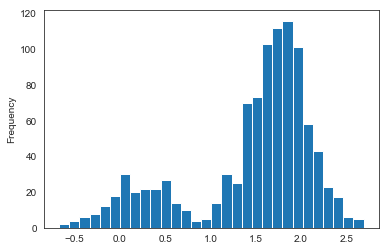

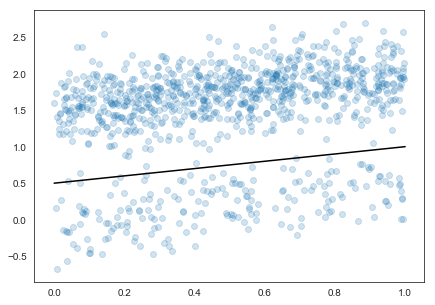

In [275]:
all_stars['y'].plot.hist(bins=30)

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(all_stars['x'], all_stars['y'], alpha=0.2)
ax.plot([0,1],[0.5, 1], c='black')

In [276]:
x = all_stars['x']
y = all_stars['y']


fit = fitting.LinearLSQFitter()
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip,
                                           niter=20, sigma=2)
g_init = models.Polynomial1D(degree=2)

or_fitted_model, mask = or_fit(g_init, x, y)
filtered_data = np.ma.masked_array(y, mask=mask)
fitted_model = fit(g_init, x, y)

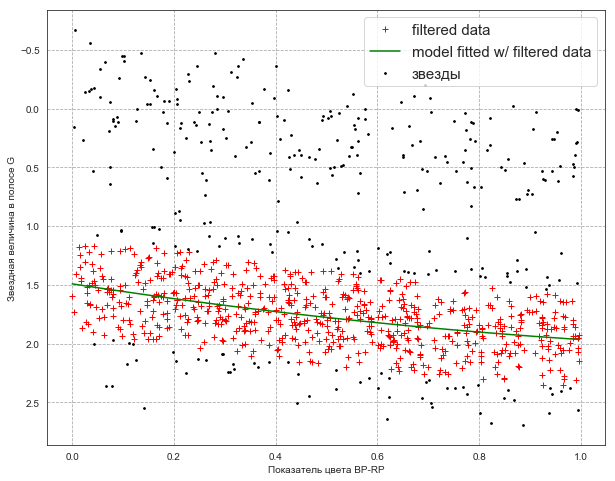

In [277]:
fig, ax = plt.subplots(figsize=(10,8 ))
ax.scatter (all_stars['x'][mask] , all_stars['y'][mask] , c ='black', s = 3, label ='звезды')
#ax.plot(isochrone['bp-rp, mag'],func_iso(isochrone['bp-rp, mag']) , c ='red', lw = 1.5, label ='полином')
ax.plot(x, filtered_data, 'r+', label="filtered data")
ax.plot(x, or_fitted_model(x), color='green', label="model fitted w/ filtered data")

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend(fontsize = 15)
#plt.savefig("polynomial_approximation.pdf", bbox_inches = 'tight')

In [278]:
all_stars['y_new'] = all_stars['y'] - or_fitted_model(all_stars['x'])
filtered_data_ = filtered_data - or_fitted_model(x)

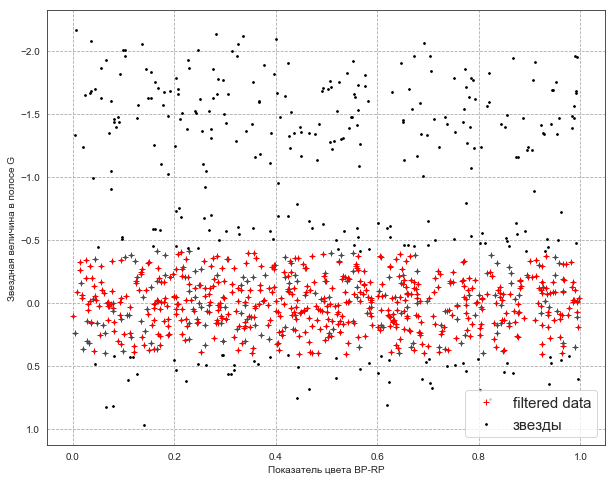

In [279]:
fig, ax = plt.subplots(figsize=(10,8 ))
ax.scatter (all_stars['x'] , all_stars['y_new'] , c ='black', s = 3, label ='звезды')
#ax.plot(isochrone['bp-rp, mag'],func_iso(isochrone['bp-rp, mag']) , c ='red', lw = 1.5, label ='полином')
ax.plot(x, filtered_data_, 'r+', label="filtered data")
#ax.plot(x, or_fitted_model(x), color='green', label="model fitted w/ filtered data")

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend(fontsize = 15)
#plt.savefig("polynomial_approximation.pdf", bbox_inches = 'tight')

(array([23., 28., 29., 31., 37., 48., 41., 58., 53., 64., 57., 63., 53.,
        56., 28., 46., 25., 33., 35.]),
 array([-0.41029187, -0.36728167, -0.32427148, -0.28126128, -0.23825108,
        -0.19524088, -0.15223068, -0.10922049, -0.06621029, -0.02320009,
         0.01981011,  0.0628203 ,  0.1058305 ,  0.1488407 ,  0.1918509 ,
         0.2348611 ,  0.27787129,  0.32088149,  0.36389169,  0.40690189]),
 <a list of 19 Patch objects>)

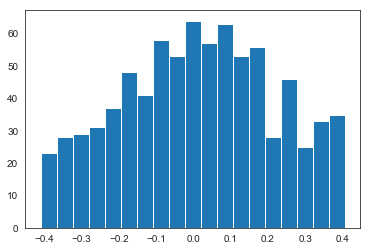

In [280]:
plt.hist(filtered_data_, bins=19)

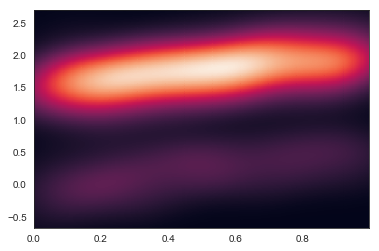

In [281]:
 # create data
x = all_stars['x']
y = all_stars['y']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
f = zi.reshape(xi.shape)

# Make the plot
plt.pcolormesh(xi, yi, f)
plt.show()


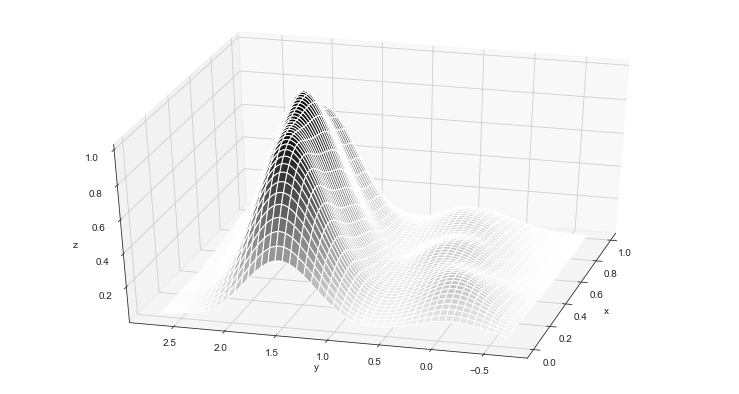

In [282]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(xi, yi, zi.reshape(xi.shape), cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(35, 195)

In [283]:
isochrone_f = pd.DataFrame()
for i in range(0,nbins-1):
    value = f[i,:].max()
    index_y = f[i,:].argmax()
    
    isochrone_f = isochrone_f.append(
                    pd.Series([xi[i,0], yi[0,index_y]]), ignore_index=True)

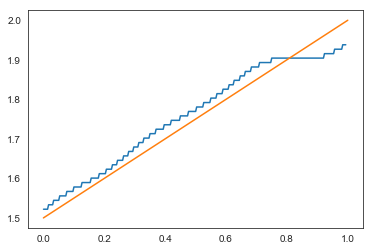

In [284]:
plt.plot(isochrone_f[0], isochrone_f[1])
plt.plot([0,1], [1.5,2])